In [2]:
! pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [3]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
#import cv2
from sklearn import tree, ensemble
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [4]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        imputer = SimpleImputer(strategy="median")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [5]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["France", "Ireland", "Southham"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(X[['Pclass']]).toarray()
        column_names = ["UpperClass", "MidClass", "WorkClass"]
        for i in range(len(column_names)):
            X[column_names[i]] = matrix.T[i]
        return X

In [6]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Name", "Ticket", "Sex", "Embarked", "Pclass", "Parch", "SibSp", "Cabin", "Age", "Fare"], axis=1)

In [7]:
titanic_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
print(test_data.head(11))
titanic_data.head(11)

    PassengerId  Pclass                                          Name     Sex  \
0           892       3                              Kelly, Mr. James    male   
1           893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2           894       2                     Myles, Mr. Thomas Francis    male   
3           895       3                              Wirz, Mr. Albert    male   
4           896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
5           897       3                    Svensson, Mr. Johan Cervin    male   
6           898       3                          Connolly, Miss. Kate  female   
7           899       2                  Caldwell, Mr. Albert Francis    male   
8           900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)  female   
9           901       3                       Davies, Mr. John Samuel    male   
10          902       3                              Ilieff, Mr. Ylio    male   

     Age  SibSp  Parch     

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [8]:
print(test_data.info())
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pcl

In [9]:
count = len(titanic_data)
print(count)
print(test_data.describe())
titanic_data.describe()

891
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


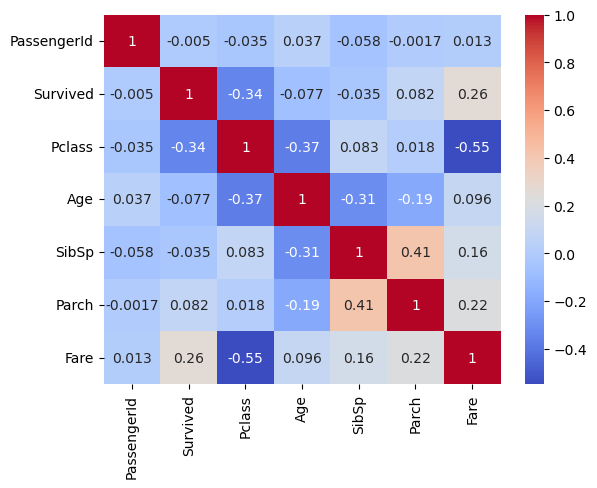

In [10]:
numerical_df = titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [11]:
columns = titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(titanic_data[titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(titanic_data[titanic_data[col].isnull()])
    if (col == 'Age'):
        AgeNaN = titanic_data[titanic_data[col].isnull()]
    if (col == 'Cabin'):
        CabinNaN = titanic_data[titanic_data[col].isnull()]
print('There are', len(titanic_data[titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 12
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Pclass column is: 0
Number of missing training values in the Name column is: 0
Number of missing training values in the Sex column is: 0
Number of missing training values in the Age column is: 177
Number of missing training values in the SibSp column is: 0
Number of missing training values in the Parch column is: 0
Number of missing training values in the Ticket column is: 0
Number of missing training values in the Fare column is: 0
Number of missing training values in the Cabin column is: 687
Number of missing training values in the Embarked column is: 2
     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelso

In [12]:
columns = test_data.columns.values
print('Number of columns in the test data is:', (len(columns)))
for col in columns:
    print('Number of missing test values in the', col, 'column is:', len(test_data[test_data[col].isnull()]))
    if (col == 'Embarked'):
        print(test_data[test_data[col].isnull()])
    if (col == 'Age'):
        AgeNaN_T = test_data[test_data[col].isnull()]
    if (col == 'Cabin'):
        CabinNaN_T = test_data[test_data[col].isnull()]
print('There are', len(test_data[test_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the test data is: 11
Number of missing test values in the PassengerId column is: 0
Number of missing test values in the Pclass column is: 0
Number of missing test values in the Name column is: 0
Number of missing test values in the Sex column is: 0
Number of missing test values in the Age column is: 86
Number of missing test values in the SibSp column is: 0
Number of missing test values in the Parch column is: 0
Number of missing test values in the Ticket column is: 0
Number of missing test values in the Fare column is: 1
Number of missing test values in the Cabin column is: 327
Number of missing test values in the Embarked column is: 0
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []
There are 331 rows with missing values


In [13]:
print(AgeNaN.index)
AgeNaN.head(11)

Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
       ...
       832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
      dtype='int64', length=177)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C


In [14]:
print(CabinNaN.index)
CabinNaN.head(11)

Index([  0,   2,   4,   5,   7,   8,   9,  12,  13,  14,
       ...
       878, 880, 881, 882, 883, 884, 885, 886, 888, 890],
      dtype='int64', length=687)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S


In [15]:
pipeline2 = Pipeline([
    ('imputer', AgeImputer()),
    ('encoder', FeatureEncoder()),
    ('dropper', FeatureDropper())
])

In [16]:
pipeline1 = Pipeline([
    ('encoder', FeatureEncoder()),
    ('dropper', FeatureDropper())
])

In [17]:
strat_titanic_data = pipeline1.fit_transform(titanic_data)
strat_test_data = pipeline2.fit_transform(test_data)
#strat_titanic_data = titanic_data.drop(["Name", "Ticket", "Sex", "Parch", "SibSp", "Pclass", "Embarked", "Age", "Cabin", "Fare"], axis=1)

In [18]:
#strat_titanic_data = pipeline.fit_transform(titanic_data)
strat_titanic_data["Female"] = strat_titanic_data["Female"].astype(int)
strat_titanic_data["Male"] = strat_titanic_data["Male"].astype(int)
strat_titanic_data["France"] = strat_titanic_data["France"].astype(int)
strat_titanic_data["Ireland"] = strat_titanic_data["Ireland"].astype(int)
strat_titanic_data["Southham"] = strat_titanic_data["Southham"].astype(int)
strat_titanic_data["UpperClass"] = strat_titanic_data["UpperClass"].astype(int)
strat_titanic_data["MidClass"] = strat_titanic_data["MidClass"].astype(int)
strat_titanic_data["WorkClass"] = strat_titanic_data["WorkClass"].astype(int)
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,1,0,0,1,0,0,1,0,0,1
1,2,1,1,0,1,0,0,1,0,0
2,3,1,1,0,0,0,1,0,0,1
3,4,1,1,0,0,0,1,1,0,0
4,5,0,0,1,0,0,1,0,0,1
5,6,0,0,1,0,1,0,0,0,1
6,7,0,0,1,0,0,1,1,0,0
7,8,0,0,1,0,0,1,0,0,1
8,9,1,1,0,0,0,1,0,0,1
9,10,1,1,0,1,0,0,0,1,0


In [19]:
#strat_titanic_data = pipeline.fit_transform(titanic_data)
strat_test_data["Female"] = strat_test_data["Female"].astype(int)
strat_test_data["Male"] = strat_test_data["Male"].astype(int)
strat_test_data["France"] = strat_test_data["France"].astype(int)
strat_test_data["Ireland"] = strat_test_data["Ireland"].astype(int)
strat_test_data["Southham"] = strat_test_data["Southham"].astype(int)
strat_test_data["UpperClass"] = strat_test_data["UpperClass"].astype(int)
strat_test_data["MidClass"] = strat_test_data["MidClass"].astype(int)
strat_test_data["WorkClass"] = strat_test_data["WorkClass"].astype(int)
strat_test_data.head(11)

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,892,0,1,0,1,0,0,0,1
1,893,1,0,0,0,1,0,0,1
2,894,0,1,0,1,0,0,1,0
3,895,0,1,0,0,1,0,0,1
4,896,1,0,0,0,1,0,0,1
5,897,0,1,0,0,1,0,0,1
6,898,1,0,0,1,0,0,0,1
7,899,0,1,0,0,1,0,1,0
8,900,1,0,1,0,0,0,0,1
9,901,0,1,0,0,1,0,0,1


In [20]:
strat_titanic_data.iloc[AgeNaN.head(11).index]

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
5,6,0,0,1,0,1,0,0,0,1
17,18,1,0,1,0,0,1,0,1,0
19,20,1,1,0,1,0,0,0,0,1
26,27,0,0,1,1,0,0,0,0,1
28,29,1,1,0,0,1,0,0,0,1
29,30,0,0,1,0,0,1,0,0,1
31,32,1,1,0,1,0,0,1,0,0
32,33,1,1,0,0,1,0,0,0,1
36,37,1,0,1,1,0,0,0,0,1
42,43,0,0,1,1,0,0,0,0,1


In [21]:
strat_test_data.iloc[AgeNaN_T.head(11).index]

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
10,902,0,1,0,0,1,0,0,1
22,914,1,0,0,0,1,1,0,0
29,921,0,1,1,0,0,0,0,1
33,925,1,0,0,0,1,0,0,1
36,928,1,0,0,0,1,0,0,1
39,931,0,1,0,0,1,0,0,1
41,933,0,1,0,0,1,1,0,0
47,939,0,1,0,1,0,0,0,1
54,946,0,1,1,0,0,0,1,0
58,950,0,1,0,0,1,0,0,1


In [22]:
#strat_titanic_data.iloc[CabinNaN.head(11).index]

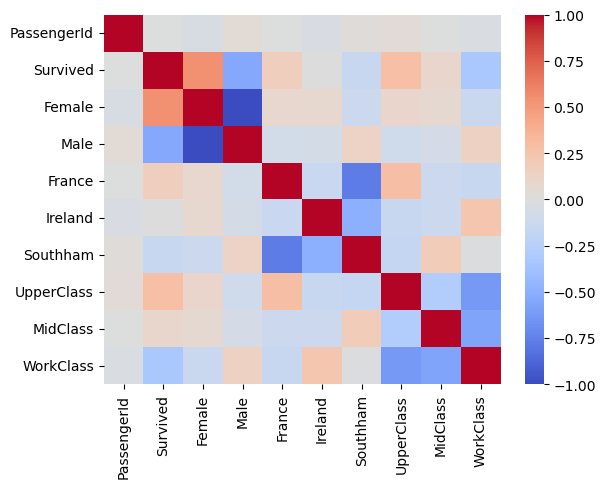

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000


In [23]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

In [24]:
#Female = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if (titanic_data.iloc[i]["Sex"] == "female"):
#        Female[i] = 1
#    else:
#        Female[i] = 0
#Female = pd.DataFrame(Female)
#strat_titanic_data["Female"] = Female

In [25]:
#strat_titanic_data["Female"] = strat_titanic_data['Female'].astype(int)
#strat_titanic_data["Male"] = strat_titanic_data['Male'].astype(int)
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
0,1,0,0,1,0,0,1,0,0,1
1,2,1,1,0,1,0,0,1,0,0
2,3,1,1,0,0,0,1,0,0,1
3,4,1,1,0,0,0,1,1,0,0
4,5,0,0,1,0,0,1,0,0,1
5,6,0,0,1,0,1,0,0,0,1
6,7,0,0,1,0,0,1,1,0,0
7,8,0,0,1,0,0,1,0,0,1
8,9,1,1,0,0,0,1,0,0,1
9,10,1,1,0,1,0,0,0,1,0


In [26]:
columns = strat_titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_titanic_data[strat_titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_titanic_data[strat_titanic_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
print('There are', len(strat_titanic_data[strat_titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 10
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [27]:
columns = strat_test_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_test_data[strat_test_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_test_data[strat_test_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_test_data[strat_test_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_ttest_data[strat_test_data[col].isnull()]
print('There are', len(strat_test_data[strat_test_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 9
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [28]:
#pd.options.mode.copy_on_write = True
#Embarked = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if(titanic_data.iloc[i]["Embarked"] == "Q"):
#        Embarked[i] = 0
#    elif (titanic_data.iloc[i]["Embarked"] == "S"):
#        Embarked[i] = 0
#    elif (titanic_data.iloc[i]["Embarked"] == "C"):
#        Embarked[i] = 2
#    else:
#        Embarked[i] = 1
#Embarked = pd.DataFrame(Embarked)
#strat_titanic_data["Embarked"] = Embarked
#print(strat_titanic_data["Embarked"].value_counts())

In [29]:
#strat_titanic_data["Embarked"] = Embarked
#print(strat_titanic_data.iloc[61], strat_titanic_data.iloc[829])
#strat_titanic_data.head(11)

In [30]:
columns = strat_titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_titanic_data[strat_titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_titanic_data[strat_titanic_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
print('There are', len(strat_titanic_data[strat_titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 10
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
There are 0 rows with missing values


In [31]:
titanic_data["Fare"].median

<bound method Series.median of 0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64>

In [32]:
DeckA = np.eye(count, 1, dtype=int)
DeckB = np.eye(count, 1, dtype=int) 
DeckC = np.eye(count, 1, dtype=int)
DeckD = np.eye(count, 1, dtype=int)
DeckE = np.eye(count, 1, dtype=int)
DeckF = np.eye(count, 1, dtype=int)
DeckG = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if (titanic_data.iloc[i]["Pclass"] == 1):
#        DeckC[i] = 1
#    elif (titanic_data.iloc[i]["Fare"] > 55):
#        DeckB[i] = 1
#    elif ((titanic_data.iloc[i]["Pclass"] == 1) & (titanic_data.iloc[i]["Fare"] > 18) & (titanic_data.iloc[i]["Fare"] < 56)):
#        DeckD[i] = 1
#    elif (titanic_data.iloc[i]["Pclass"] == 2):
#        DeckE[i] = 1
#    elif ((titanic_data.iloc[i]["Fare"] > 18) & (titanic_data.iloc[i]["Fare"] < 56)):
#        DeckF[i] = 1
#    elif ((titanic_data.iloc[i]["Fare"] > 11) & (titanic_data.iloc[i]["Fare"] < 18)):
#        DeckG[i] = 1
#    else:
#        DeckA[i] = 0

has_A = titanic_data["Cabin"].str.contains('A')
has_B = titanic_data["Cabin"].str.contains('B')
has_C = titanic_data["Cabin"].str.contains('C')
has_D = titanic_data["Cabin"].str.contains('D')
has_E = titanic_data["Cabin"].str.contains('E')
has_F = titanic_data["Cabin"].str.contains('F')
has_G = titanic_data["Cabin"].str.contains('G')

for i in range(len(strat_titanic_data)):
    if (has_A[i] == True):
        DeckA[i] = 1
    elif (has_B[i] == True):
        DeckB[i] = 1
    elif (has_C[i] == True):
        DeckC[i]=1
    elif (has_D[i] == True):
        DeckD[i] = 1
    elif (has_E[i] == True):
        DeckE[i] = 1
    elif (has_F[i] == True):
        DeckF[i] = 1
    elif (has_G[i] == True):
        DeckG[i] = 1
    else:
        DeckA[i] = 0
        DeckB[i] = 0
        DeckC[i] = 0
        DeckD[i] = 0
        DeckE[i] = 0
        DeckF[i] = 0
        DeckG[i] = 0

DeckA = pd.DataFrame(DeckA)
DeckB = pd.DataFrame(DeckB)
DeckC = pd.DataFrame(DeckC)
DeckD = pd.DataFrame(DeckD)
DeckE = pd.DataFrame(DeckE)
DeckF = pd.DataFrame(DeckF)
DeckG = pd.DataFrame(DeckG)

strat_titanic_data["DeckA"] = DeckA
strat_titanic_data["DeckB"] = DeckB
strat_titanic_data["DeckC"] = DeckC
strat_titanic_data["DeckD"] = DeckD
strat_titanic_data["DeckE"] = DeckE
strat_titanic_data["DeckF"] = DeckF
strat_titanic_data["DeckG"] = DeckG
print(strat_titanic_data["DeckA"].value_counts())
print(strat_titanic_data["DeckB"].value_counts())
print(strat_titanic_data["DeckC"].value_counts())
print(strat_titanic_data["DeckD"].value_counts())
print(strat_titanic_data["DeckE"].value_counts())
print(strat_titanic_data["DeckF"].value_counts())
print(strat_titanic_data["DeckG"].value_counts())

DeckA
0    876
1     15
Name: count, dtype: int64
DeckB
0    844
1     47
Name: count, dtype: int64
DeckC
0    832
1     59
Name: count, dtype: int64
DeckD
0    858
1     33
Name: count, dtype: int64
DeckE
0    858
1     33
Name: count, dtype: int64
DeckF
0    879
1     12
Name: count, dtype: int64
DeckG
0    887
1      4
Name: count, dtype: int64


In [33]:
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
1,2,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0
2,3,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,4,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0
4,5,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
5,6,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
6,7,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0
7,8,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
8,9,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
9,10,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [34]:
columns = strat_titanic_data.columns.values
print('Number of columns in the training data is:', (len(columns)))
for col in columns:
    print('Number of missing training values in the', col, 'column is:', len(strat_titanic_data[strat_titanic_data[col].isnull()]))
    if (col == 'Embarked'):
        print(strat_titanic_data[strat_titanic_data[col].isnull()])
    #if (col == 'Age'):
        #AgeNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
    #if (col == 'Cabin'):
        #CabinNaN = strat_titanic_data[strat_titanic_data[col].isnull()]
print('There are', len(strat_titanic_data[strat_titanic_data.isnull().any(axis=1)]), 'rows with missing values')

Number of columns in the training data is: 17
Number of missing training values in the PassengerId column is: 0
Number of missing training values in the Survived column is: 0
Number of missing training values in the Female column is: 0
Number of missing training values in the Male column is: 0
Number of missing training values in the France column is: 0
Number of missing training values in the Ireland column is: 0
Number of missing training values in the Southham column is: 0
Number of missing training values in the UpperClass column is: 0
Number of missing training values in the MidClass column is: 0
Number of missing training values in the WorkClass column is: 0
Number of missing training values in the DeckA column is: 0
Number of missing training values in the DeckB column is: 0
Number of missing training values in the DeckC column is: 0
Number of missing training values in the DeckD column is: 0
Number of missing training values in the DeckE column is: 0
Number of missing training 

In [35]:
strat_titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Female       891 non-null    int64
 3   Male         891 non-null    int64
 4   France       891 non-null    int64
 5   Ireland      891 non-null    int64
 6   Southham     891 non-null    int64
 7   UpperClass   891 non-null    int64
 8   MidClass     891 non-null    int64
 9   WorkClass    891 non-null    int64
 10  DeckA        891 non-null    int64
 11  DeckB        891 non-null    int64
 12  DeckC        891 non-null    int64
 13  DeckD        891 non-null    int64
 14  DeckE        891 non-null    int64
 15  DeckF        891 non-null    int64
 16  DeckG        891 non-null    int64
dtypes: int64(17)
memory usage: 118.5 KB


In [36]:
strat_titanic_data.describe()

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,0.352413,0.647587,0.188552,0.086420,0.722783,0.242424,0.206510,0.551066,0.016835,0.052750,0.066218,0.037037,0.037037,0.013468,0.004489
std,257.353842,0.486592,0.477990,0.477990,0.391372,0.281141,0.447876,0.428790,0.405028,0.497665,0.128725,0.223659,0.248802,0.188959,0.188959,0.115332,0.066890
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,891.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


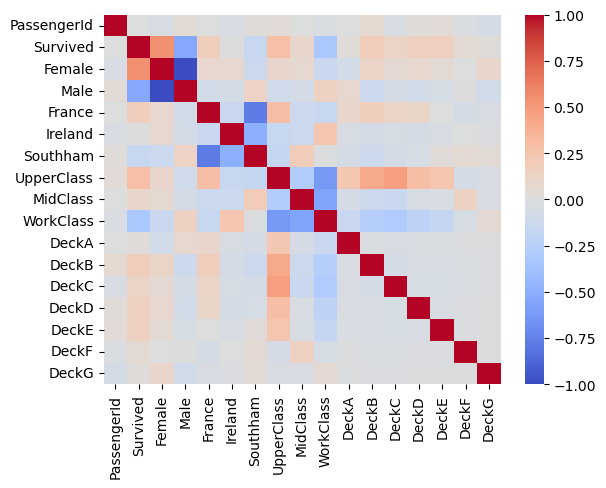

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,DeckD,DeckE,DeckF,DeckG
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486,-0.003256,0.069552,-0.040957,0.022828,0.034404,-0.025212,-0.060049
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308,0.022287,0.175095,0.114652,0.150716,0.150716,0.047930,0.016040
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143,-0.078271,0.109689,0.058649,0.079248,0.054368,-0.004667,0.091031
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143,0.078271,-0.109689,-0.058649,-0.079248,-0.054368,0.004667,-0.091031
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329,0.093040,0.168642,0.113952,0.102977,-0.003376,-0.056322,-0.032371
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449,-0.040246,-0.072579,-0.049776,-0.060318,-0.039167,-0.001283,-0.020654
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511,-0.055383,-0.123057,-0.066995,-0.051139,0.028520,0.050608,0.041589
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738,0.231323,0.417160,0.470749,0.291218,0.235748,-0.066095,-0.037988
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210,-0.066756,-0.120386,-0.135851,-0.041325,-0.041325,0.132819,-0.034258
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000,-0.144979,-0.261450,-0.295036,-0.217282,-0.169489,-0.051148,0.060612


In [37]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

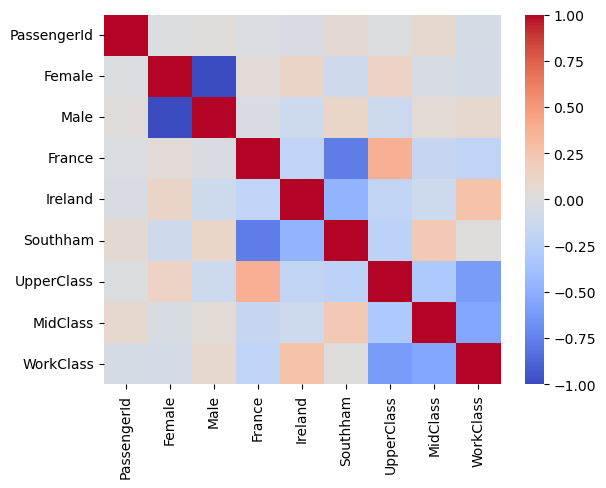

,PassengerId,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass
PassengerId,1.000000,-0.023245,0.023245,-0.027419,-0.035731,0.048008,-0.011062,0.077295,-0.054692
Female,-0.023245,1.000000,-1.000000,0.033684,0.115574,-0.105883,0.126389,-0.045655,-0.072405
Male,0.023245,-1.000000,1.000000,-0.033684,-0.115574,0.105883,-0.126389,0.045655,0.072405
France,-0.027419,0.033684,-0.033684,1.000000,-0.199786,-0.767375,0.381492,-0.156605,-0.202894
Ireland,-0.035731,0.115574,-0.115574,-0.199786,1.000000,-0.474962,-0.188745,-0.114588,0.260301
Southham,0.048008,-0.105883,0.105883,-0.767375,-0.474962,1.000000,-0.219110,0.215634,0.011883
UpperClass,-0.011062,0.126389,-0.126389,0.381492,-0.188745,-0.219110,1.000000,-0.313770,-0.612386
MidClass,0.077295,-0.045655,0.045655,-0.156605,-0.114588,0.215634,-0.313770,1.000000,-0.558487
WorkClass,-0.054692,-0.072405,0.072405,-0.202894,0.260301,0.011883,-0.612386,-0.558487,1.000000


In [38]:
numerical_T_df = strat_test_data.select_dtypes(include=[np.number])
correlation_matrix_T = numerical_T_df.corr()
sns.heatmap(correlation_matrix_T, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix_T

In [39]:
Infant = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] <= 5):
        Infant[i] = 1
    else:
        Infant[i] = 0
Infant = pd.DataFrame(Infant)
strat_titanic_data["Infant"] = Infant
print(strat_titanic_data["Infant"].value_counts())

Infant
0    847
1     44
Name: count, dtype: int64


In [40]:
Older = np.eye(count, 1, dtype=int)
VOld = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 63) & (titanic_data.iloc[i]["Age"] < 75):
        Older[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 74):
        VOld[i] = 1
    else:
        Older[i] = 0
        VOld[i] = 0
Older = pd.DataFrame(Older)
VOld = pd.DataFrame(VOld)
strat_titanic_data["Older"] = Older
strat_titanic_data["VOld"] = VOld
print(strat_titanic_data["Older"].value_counts())
print(strat_titanic_data["VOld"].value_counts())

Older
0    879
1     12
Name: count, dtype: int64
VOld
0    890
1      1
Name: count, dtype: int64


In [41]:
Teen = np.eye(count, 1, dtype=int)
Child = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 12) & (titanic_data.iloc[i]["Age"] <= 18):
        Teen[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 5) & (titanic_data.iloc[i]["Age"] <= 12):
        Child[i] = 1     
    else:
        Teen[i] = 0
        Child[i] = 0
Teen = pd.DataFrame(Teen)
Child = pd.DataFrame(Child)
strat_titanic_data["Teen"] = Teen
strat_titanic_data["Child"] = Child
print(strat_titanic_data["Teen"].value_counts())
print(strat_titanic_data["Child"].value_counts())

Teen
0    821
1     70
Name: count, dtype: int64
Child
0    866
1     25
Name: count, dtype: int64


In [42]:
Adult = np.eye(count, 1, dtype=int)
MidLife = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Age"] <= 40):
        Adult[i] = 1
    elif (titanic_data.iloc[i]["Age"] > 40) & (titanic_data.iloc[i]["Age"] <= 63):
        MidLife[i] = 1
    else:
        Adult[i] = 0
        MidLife[i] = 0
Adult = pd.DataFrame(Adult)
MidLife = pd.DataFrame(MidLife)
strat_titanic_data["Adult"] = Adult
strat_titanic_data["MidLife"] = MidLife
print(strat_titanic_data["Adult"].value_counts())
print(strat_titanic_data["MidLife"].value_counts())

Adult
0    466
1    425
Name: count, dtype: int64
MidLife
0    753
1    138
Name: count, dtype: int64


In [43]:
#print(strat_titanic_data["Age"].value_counts())
#print(strat_titanic_data["Age"].median())
#print(strat_titanic_data["Age"].mean())
#print(strat_titanic_data["Age"].max())

In [44]:
#strat_titanic_data["Female"] = strat_titanic_data['Female'].astype(int)
#strat_titanic_data["Male"] = strat_titanic_data['Male'].astype(int)
strat_titanic_data.head(11)

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,...,DeckE,DeckF,DeckG,Infant,Older,VOld,Teen,Child,Adult,MidLife
0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,4,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,6,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,1
7,8,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
8,9,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,10,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [45]:
#Class = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if (titanic_data.iloc[i]["Pclass"] == 1):
#        Class[i] = 2
#    elif (titanic_data.iloc[i]["Pclass"] == 2):
#        Class[i] = 1
#    else:
#        Class[i] = 0
#Class = pd.DataFrame(Class)
#strat_titanic_data["Class"] = Class
#strat_titanic_data.head(11)

In [46]:
Family = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Parch"] == 3):
        Family[i] = 5
    elif (titanic_data.iloc[i]["Parch"] == 1):
        Family[i] = 4
    elif (titanic_data.iloc[i]["Parch"] == 2):
        Family[i] = 3
    elif (titanic_data.iloc[i]["Parch"] == 0):
        Family[i] = 2
    elif (titanic_data.iloc[i]["Parch"] == 5):
        Family[i] = 1
    else:
        Family[i] = 0
Family = pd.DataFrame(Family)
strat_titanic_data["Family"] = Family
print(strat_titanic_data["Family"].value_counts())

Family
2    678
4    118
3     80
1      5
5      5
0      5
Name: count, dtype: int64


In [47]:
Sibling = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["SibSp"] == 1):
        Sibling[i] = 5
    elif (titanic_data.iloc[i]["SibSp"] == 2):
        Sibling[i] = 4
    elif (titanic_data.iloc[i]["SibSp"] == 0):
        Sibling[i] = 3
    elif (titanic_data.iloc[i]["SibSp"] == 3):
        Sibling[i] = 2
    elif (titanic_data.iloc[i]["SibSp"] == 4):
        Sibling[i] = 1
    else:
        Sibling[i] = 0
Sibling = pd.DataFrame(Sibling)
strat_titanic_data["Sibling"] = Sibling
print(strat_titanic_data["Sibling"].value_counts())

Sibling
3    608
5    209
4     28
1     18
2     16
0     12
Name: count, dtype: int64


In [48]:
#AgeFactor = np.eye(count, 1, dtype=int)
#for i in range(count):
#    if ((titanic_data.iloc[i]["Age"] > 18) & (titanic_data.iloc[i]["Age"] < 36)):
#        AgeFactor[i] = 2
#    elif ((titanic_data.iloc[i]["Age"] > 36) & (titanic_data.iloc[i]["Age"] < 64)):
#        AgeFactor[i] = 1
#    elif ((titanic_data.iloc[i]["Age"] > 5) & (titanic_data.iloc[i]["Age"] <=18)):
#        AgeFactor[i] = 0
#    elif ((titanic_data.iloc[i]["Age"] > 64) & (titanic_data.iloc[i]["Age"] < 76)):
#        AgeFactor[i] = 0
#    else:
#        AgeFactor[i] = 1
#Age = pd.DataFrame(AgeFactor)
#strat_titanic_data["AgeFactor"] = AgeFactor
#strat_titanic_data["AgeFactor"].value_counts()

In [49]:
#Age = np.eye(count, 1, dtype=float)
#for i in range(count):
#    Age[i] = titanic_data.iloc[i]["Age"]
#for i in (AgeNaN.index):
#    Age[i] = 40
#Age = pd.DataFrame(Age)
#strat_titanic_data["Age"] = Age
#strat_titanic_data.iloc[AgeNaN.head(11).index]

In [50]:
FareSHigh = np.eye(count, 1, dtype=int)
FareVHigh = np.eye(count, 1, dtype=int)
FareHigh = np.eye(count, 1, dtype=int)
FareMid = np.eye(count, 1, dtype=int)
FareLMid = np.eye(count, 1, dtype=int)
FareLow = np.eye(count, 1, dtype=int)
FareVLow = np.eye(count, 1, dtype=int)
for i in range(count):
    if (titanic_data.iloc[i]["Fare"] > 300):
        FareSHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 200) & (titanic_data.iloc[i]["Fare"] <= 300)):
        FareVHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 100) & (titanic_data.iloc[i]["Fare"] <=200)):
        FareHigh[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 50) & (titanic_data.iloc[i]["Fare"] <=100)):
        FareMid[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 29) & (titanic_data.iloc[i]["Fare"] <= 50)):
        FareLMid[i] = 1
    elif ((titanic_data.iloc[i]["Fare"] > 10) & (titanic_data.iloc[i]["Fare"] <= 29)):
        FareLow[i] = 1
    elif (titanic_data.iloc[i]["Fare"] <= 10):
        FareVLow[i] = 1
    else:
        FareSHigh[i] = 0
        FareVHigh[i] = 0
        FareHigh[i] = 0
        FareMid[i] = 0
        FareLMid[i] = 0
        FareLow[i] = 0
        FareVLow[i] = 0
FareSHigh = pd.DataFrame(FareSHigh)
FareVHigh = pd.DataFrame(FareVHigh)
FareHigh = pd.DataFrame(FareHigh)
FareMid = pd.DataFrame(FareMid)
FareLMid = pd.DataFrame(FareLMid)
FareLow = pd.DataFrame(FareLow)
FareVLow = pd.DataFrame(FareVLow)
strat_titanic_data["FareSHigh"] = FareSHigh
strat_titanic_data["FareVHigh"] = FareVHigh
strat_titanic_data["FareHigh"] = FareHigh
strat_titanic_data["FareMid"] = FareMid
strat_titanic_data["FareLMid"] = FareLMid
strat_titanic_data["FareLow"] = FareLow
strat_titanic_data["FareVLow"] = FareVLow

print(strat_titanic_data["FareSHigh"].value_counts())
print(strat_titanic_data["FareVHigh"].value_counts())
print(strat_titanic_data["FareHigh"].value_counts())
print(strat_titanic_data["FareMid"].value_counts())
print(strat_titanic_data["FareLMid"].value_counts())
print(strat_titanic_data["FareLow"].value_counts())
print(strat_titanic_data["FareVLow"].value_counts())

FareSHigh
0    887
1      4
Name: count, dtype: int64
FareVHigh
0    873
1     18
Name: count, dtype: int64
FareHigh
0    857
1     34
Name: count, dtype: int64
FareMid
0    783
1    108
Name: count, dtype: int64
FareLMid
0    802
1     89
Name: count, dtype: int64
FareLow
0    583
1    308
Name: count, dtype: int64
FareVLow
0    555
1    336
Name: count, dtype: int64


In [51]:
print(strat_titanic_data.head(11))
strat_titanic_data_age = strat_titanic_data.drop(AgeNaN.index, axis=0)
print(strat_titanic_data_age.head(11))
print(len(strat_titanic_data_age))

    PassengerId  Survived  Female  Male  France  Ireland  Southham  \
0             1         0       0     1       0        0         1   
1             2         1       1     0       1        0         0   
2             3         1       1     0       0        0         1   
3             4         1       1     0       0        0         1   
4             5         0       0     1       0        0         1   
5             6         0       0     1       0        1         0   
6             7         0       0     1       0        0         1   
7             8         0       0     1       0        0         1   
8             9         1       1     0       0        0         1   
9            10         1       1     0       1        0         0   
10           11         1       1     0       0        0         1   

    UpperClass  MidClass  WorkClass  ...  MidLife  Family  Sibling  FareSHigh  \
0            0         0          1  ...        1       2        5          1 

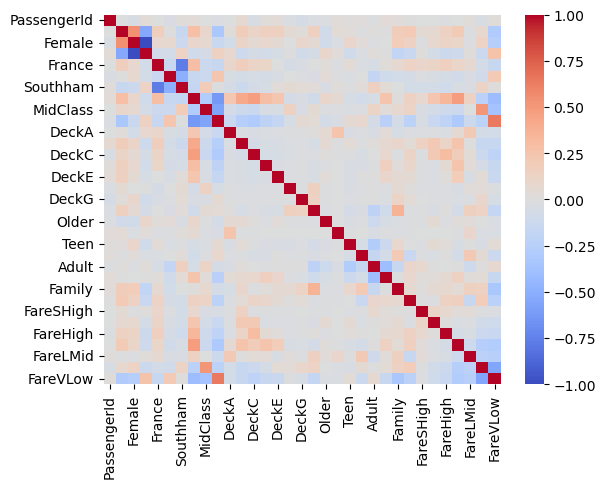

,PassengerId,Survived,Female,Male,France,Ireland,Southham,UpperClass,MidClass,WorkClass,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
PassengerId,1.000000,-0.005007,-0.042939,0.042939,-0.001205,-0.033606,0.022148,0.034303,-0.000086,-0.029486,...,0.036424,0.024485,0.007036,-0.006919,-0.005924,-0.009361,-0.002941,0.017128,-0.042719,0.015639
Survived,-0.005007,1.000000,0.543351,-0.543351,0.168240,0.003650,-0.155660,0.285904,0.093349,-0.322308,...,0.006572,0.172991,0.203889,0.050561,0.067105,0.143946,0.201847,-0.008940,0.071710,-0.295081
Female,-0.042939,0.543351,1.000000,-1.000000,0.082853,0.074115,-0.125722,0.098013,0.064746,-0.137143,...,-0.004110,0.185204,0.147900,-0.014396,0.077758,0.122850,0.107539,-0.018528,0.125753,-0.263751
Male,0.042939,-0.543351,-1.000000,1.000000,-0.082853,-0.074115,0.125722,-0.098013,-0.064746,0.137143,...,0.004110,-0.185204,-0.147900,0.014396,-0.077758,-0.122850,-0.107539,0.018528,-0.125753,0.263751
France,-0.001205,0.168240,0.082853,-0.082853,1.000000,-0.148258,-0.778359,0.296423,-0.125416,-0.153329,...,0.015701,0.066061,0.125914,0.096390,0.114332,0.158595,0.102301,0.069078,-0.072845,-0.156019
Ireland,-0.033606,0.003650,0.074115,-0.074115,-0.148258,1.000000,-0.496624,-0.155342,-0.127301,0.237449,...,-0.098545,-0.080828,-0.054904,-0.020654,-0.044163,-0.061261,-0.089749,-0.035852,-0.089171,0.205731
Southham,0.022148,-0.155660,-0.125722,0.125722,-0.778359,-0.496624,1.000000,-0.170379,0.192061,-0.009511,...,0.043355,-0.004639,-0.073577,-0.070928,-0.071466,-0.099133,-0.046560,-0.036188,0.123274,0.011096
UpperClass,0.034303,0.285904,0.098013,-0.098013,0.296423,-0.155342,-0.170379,1.000000,-0.288585,-0.626738,...,0.250065,0.015211,0.147762,0.079537,0.235222,0.338436,0.479998,0.143451,-0.229445,-0.407726
MidClass,-0.000086,0.093349,0.064746,-0.064746,-0.125416,-0.127301,0.192061,-0.288585,1.000000,-0.565210,...,0.026835,0.076022,0.117762,-0.034258,-0.073253,-0.101613,-0.130000,-0.003508,0.521150,-0.362614
WorkClass,-0.029486,-0.322308,-0.137143,0.137143,-0.153329,0.237449,-0.009511,-0.626738,-0.565210,1.000000,...,-0.237297,-0.074977,-0.223154,-0.040648,-0.143050,-0.208900,-0.307767,-0.120743,-0.226451,0.646414


In [52]:
numerical_df = strat_titanic_data.select_dtypes(include=[np.number])
#numerical_df = numerical_df.drop(["PassengerId"], axis=1)
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.show()
correlation_matrix

In [53]:
#strat_titanic_data_age = strat_titanic_data_age.reset_index(drop=True)
#strat_titanic_data_age = strat_titanic_data_age.drop(["PassengerId"], axis=1)
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
#for train_indices, valid_indices in split.split(strat_titanic_data_age, strat_titanic_data_age[["Survived", "Female"]]):
#    strat_train_set = strat_titanic_data_age.loc[train_indices]
#    strat_valid_set = strat_titanic_data_age.loc[valid_indices]

In [54]:
#strat_titanic_data.iloc[AgeNaN.head(11).index]["MidLife"] = 1
#strat_titanic_data = strat_titanic_data.drop(["MidLife"], axis=1)
strat_titanic_data = strat_titanic_data.drop(["PassengerId", "Ireland"], axis=1)
#strat_titanic_data = strat_titanic_data.drop(["PassengerId", "Ireland", "FareLMid"], axis=1)
#strat_titanic_data = strat_titanic_data.drop(["PassengerId", "Ireland", "FareLMid", "Child"], axis=1)
#strat_titanic_data = strat_titanic_data.drop(["PassengerId", "Ireland", "Child", "FareLMid", "Bstard", "Adult", "MidLife"], axis=1)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, valid_indices in split.split(strat_titanic_data, strat_titanic_data[["Survived", "Female"]]):
    strat_train_set = strat_titanic_data.loc[train_indices]
    strat_valid_set = strat_titanic_data.loc[valid_indices]

In [55]:
strat_train_set.head(11)

,Survived,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
575,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,1,0
359,1,1,0,0,0,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
10,1,1,0,0,1,0,0,1,0,0,...,0,4,5,0,0,0,0,0,1,0
387,1,1,0,0,1,0,1,0,0,0,...,0,2,3,0,0,0,0,0,1,0
16,0,0,1,0,0,0,0,1,0,0,...,0,4,1,0,0,0,0,1,0,0
43,1,1,0,1,0,0,1,0,0,0,...,0,3,5,0,0,0,0,1,0,0
250,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
839,1,0,1,1,0,1,0,0,0,0,...,0,2,3,0,0,0,0,1,0,0
13,0,0,1,0,1,0,0,1,0,0,...,0,1,5,0,0,0,0,1,0,0
559,1,1,0,0,1,0,0,1,0,0,...,0,2,5,0,0,0,0,0,1,0


In [56]:
strat_valid_set.head(11)

,Survived,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
132,0,1,0,0,1,0,0,1,0,0,...,1,2,5,0,0,0,0,0,1,0
585,1,1,0,0,1,1,0,0,0,0,...,0,3,3,0,0,0,1,0,0,0
571,1,1,0,0,1,1,0,0,0,0,...,1,2,4,0,0,0,1,0,0,0
508,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,1,0
188,0,0,1,0,0,0,0,1,0,0,...,0,4,5,0,0,0,0,0,1,0
106,1,1,0,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
300,1,1,0,0,0,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
22,1,1,0,0,0,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
461,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
448,1,1,0,1,0,0,0,1,0,0,...,0,4,4,0,0,0,0,0,1,0


In [57]:
print(strat_train_set.info(), strat_valid_set.info())

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 575 to 472
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    712 non-null    int64
 1   Female      712 non-null    int64
 2   Male        712 non-null    int64
 3   France      712 non-null    int64
 4   Southham    712 non-null    int64
 5   UpperClass  712 non-null    int64
 6   MidClass    712 non-null    int64
 7   WorkClass   712 non-null    int64
 8   DeckA       712 non-null    int64
 9   DeckB       712 non-null    int64
 10  DeckC       712 non-null    int64
 11  DeckD       712 non-null    int64
 12  DeckE       712 non-null    int64
 13  DeckF       712 non-null    int64
 14  DeckG       712 non-null    int64
 15  Infant      712 non-null    int64
 16  Older       712 non-null    int64
 17  VOld        712 non-null    int64
 18  Teen        712 non-null    int64
 19  Child       712 non-null    int64
 20  Adult       712 non-null    int64
 

<function matplotlib.pyplot.show(close=None, block=None)>

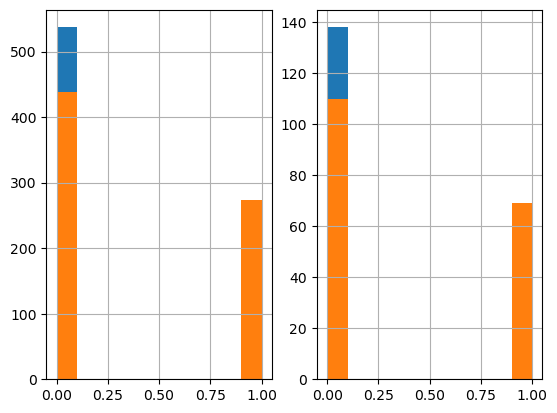

In [58]:
plt.subplot(1,2,1)
strat_train_set['UpperClass'].hist()
strat_train_set['Survived'].hist()

plt.subplot(1,2,2)
strat_valid_set['UpperClass'].hist()
strat_valid_set['Survived'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

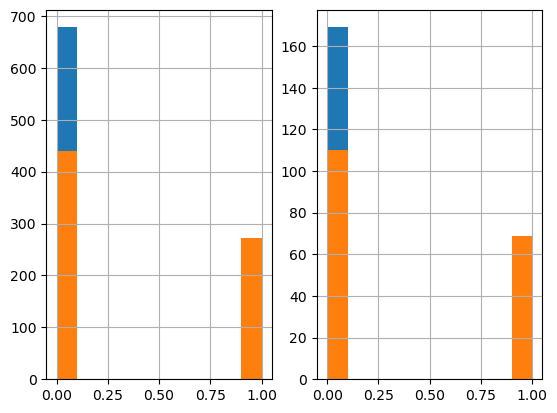

In [59]:
plt.subplot(1,2,1)
strat_train_set['Infant'].hist()
strat_train_set['Survived'].hist()

plt.subplot(1,2,2)
strat_valid_set['Infant'].hist()
strat_valid_set['Survived'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

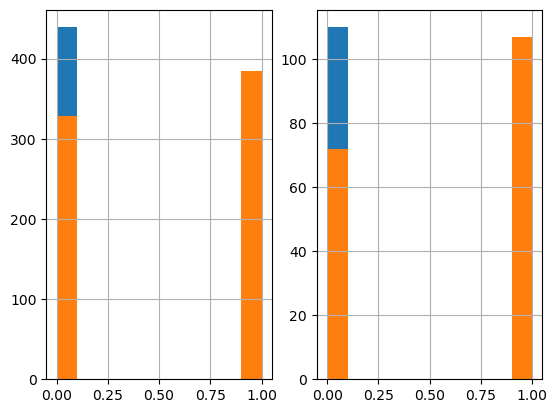

In [60]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['WorkClass'].hist()

plt.subplot(1,2,2)
strat_valid_set['Survived'].hist()
strat_valid_set['WorkClass'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

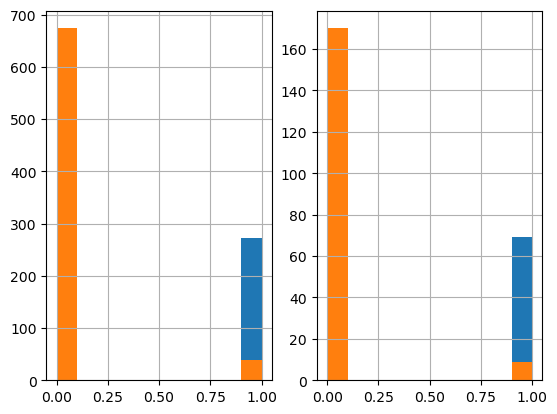

In [61]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['DeckB'].hist()

plt.subplot(1,2,2)
strat_valid_set['Survived'].hist()
strat_valid_set['DeckB'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

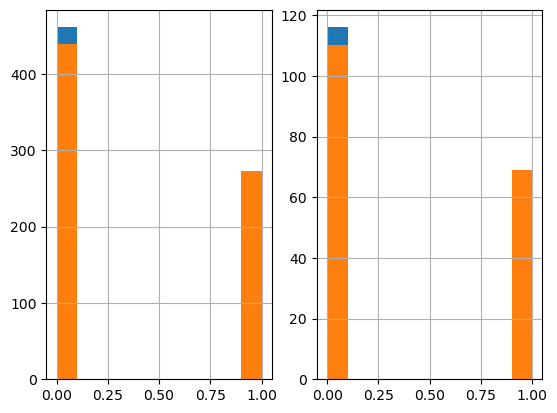

In [62]:
plt.subplot(1,2,1)
strat_train_set['Female'].hist()
strat_train_set['Survived'].hist()

plt.subplot(1,2,2)
strat_valid_set['Female'].hist()
strat_valid_set['Survived'].hist()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

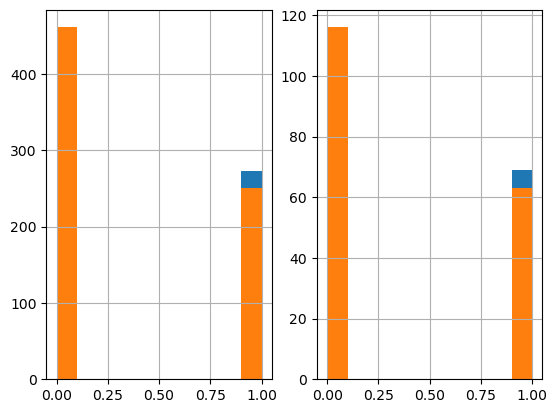

In [63]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Female'].hist()

plt.subplot(1,2,2)
strat_valid_set['Survived'].hist()
strat_valid_set['Female'].hist()

plt.show

In [64]:
X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']
Xv = strat_valid_set.drop(['Survived'], axis=1)
yv = strat_valid_set['Survived']

#X, y = load_iris(return_X_y=True)
#scaler = StandardScaler()
#X_data = scaler.fit_transform(X)
#Xv_data = scaler.fit_transform(Xv)
X_data = X
Xv_data = Xv
y_data = y.to_numpy()
yv_data = yv.to_numpy()
X, y = load_iris(return_X_y=True)
Xv, yv = load_iris(return_X_y=True)
X_dataNB = X
Xv_dataNB = Xv
y_dataNB = y
yv_dataNB = yv

In [65]:
strat_train_set.head(11)

,Survived,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
575,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,1,0
359,1,1,0,0,0,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
10,1,1,0,0,1,0,0,1,0,0,...,0,4,5,0,0,0,0,0,1,0
387,1,1,0,0,1,0,1,0,0,0,...,0,2,3,0,0,0,0,0,1,0
16,0,0,1,0,0,0,0,1,0,0,...,0,4,1,0,0,0,0,1,0,0
43,1,1,0,1,0,0,1,0,0,0,...,0,3,5,0,0,0,0,1,0,0
250,0,0,1,0,1,0,0,1,0,0,...,0,2,3,0,0,0,0,0,0,1
839,1,0,1,1,0,1,0,0,0,0,...,0,2,3,0,0,0,0,1,0,0
13,0,0,1,0,1,0,0,1,0,0,...,0,1,5,0,0,0,0,1,0,0
559,1,1,0,0,1,0,0,1,0,0,...,0,2,5,0,0,0,0,0,1,0


In [66]:
X_data

,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
575,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,1,0
359,1,0,0,0,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
10,1,0,0,1,0,0,1,0,0,0,...,0,4,5,0,0,0,0,0,1,0
387,1,0,0,1,0,1,0,0,0,0,...,0,2,3,0,0,0,0,0,1,0
16,0,1,0,0,0,0,1,0,0,0,...,0,4,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0,1,0,1,1,0,0,0,0,0,...,0,2,3,0,0,0,0,1,0,0
649,1,0,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
232,0,1,0,1,0,1,0,0,0,0,...,1,2,3,0,0,0,0,0,1,0
87,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1


In [67]:
Xv_data

,Female,Male,France,Southham,UpperClass,MidClass,WorkClass,DeckA,DeckB,DeckC,...,MidLife,Family,Sibling,FareSHigh,FareVHigh,FareHigh,FareMid,FareLMid,FareLow,FareVLow
132,1,0,0,1,0,0,1,0,0,0,...,1,2,5,0,0,0,0,0,1,0
585,1,0,0,1,1,0,0,0,0,0,...,0,3,3,0,0,0,1,0,0,0
571,1,0,0,1,1,0,0,0,0,1,...,1,2,4,0,0,0,1,0,0,0
508,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,1,0
188,0,1,0,0,0,0,1,0,0,0,...,0,4,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0,1,0,1,0,0,1,0,0,0,...,0,4,5,0,0,0,0,0,0,1
454,0,1,0,1,0,0,1,0,0,0,...,0,2,3,0,0,0,0,0,0,1
276,1,0,0,1,0,0,1,0,0,0,...,1,2,3,0,0,0,0,0,0,1
724,0,1,0,1,1,0,0,0,0,0,...,0,2,5,0,0,0,1,0,0,0


In [68]:
y_data

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,

In [69]:
yv_data

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1])

In [70]:
reg = LinearRegression()
reg.fit(X_data, y_data)
predict_ys1 = reg.predict(X_data)
predict_ys2 = np.round(predict_ys1)
predict_y = predict_ys2.astype(int)
predict_y

array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,

In [71]:
Xv_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 132 to 706
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Female      179 non-null    int64
 1   Male        179 non-null    int64
 2   France      179 non-null    int64
 3   Southham    179 non-null    int64
 4   UpperClass  179 non-null    int64
 5   MidClass    179 non-null    int64
 6   WorkClass   179 non-null    int64
 7   DeckA       179 non-null    int64
 8   DeckB       179 non-null    int64
 9   DeckC       179 non-null    int64
 10  DeckD       179 non-null    int64
 11  DeckE       179 non-null    int64
 12  DeckF       179 non-null    int64
 13  DeckG       179 non-null    int64
 14  Infant      179 non-null    int64
 15  Older       179 non-null    int64
 16  VOld        179 non-null    int64
 17  Teen        179 non-null    int64
 18  Child       179 non-null    int64
 19  Adult       179 non-null    int64
 20  MidLife     179 non-null    int64
 

In [72]:
print(Xv_data)
predict_yvs1 = reg.predict(Xv_data)
print(predict_yvs1)
predict_yvs2 = np.round(predict_yvs1)
print(predict_yvs2)
predict_yv = predict_yvs2.astype(int)
print(predict_yv)

     Female  Male  France  Southham  UpperClass  MidClass  WorkClass  DeckA  \
132       1     0       0         1           0         0          1      0   
585       1     0       0         1           1         0          0      0   
571       1     0       0         1           1         0          0      0   
508       0     1       0         1           0         0          1      0   
188       0     1       0         0           0         0          1      0   
..      ...   ...     ...       ...         ...       ...        ...    ...   
175       0     1       0         1           0         0          1      0   
454       0     1       0         1           0         0          1      0   
276       1     0       0         1           0         0          1      0   
724       0     1       0         1           1         0          0      0   
706       1     0       0         1           0         1          0      0   

     DeckB  DeckC  ...  MidLife  Family  Sibling  F

In [73]:
print('Accuracy:', accuracy_score(yv_data, predict_yv))
print('Precision:', precision_score(yv_data, predict_yv))

Accuracy: 0.8212290502793296
Precision: 0.7846153846153846


In [75]:
print('Accuracy:', accuracy_score(yv_data, predict_yv))

Accuracy: 0.8324022346368715


In [74]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)
#print(predict_yv)
#print(predict_y)

Accuracy: 0.824438202247191 Precision: 0.7890625 Recall: 0.73992673992674 F1_score: 0.7637051039697542
Accuracy: 0.8212290502793296 Precision: 0.7846153846153846 Recall: 0.7391304347826086 F1_score: 0.7611940298507462
[[385  54]
 [ 71 202]]
[[96 14]
 [18 51]]


In [77]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cm)
print(cmv)

Accuracy: 0.827247191011236 Precision: 0.8 Recall: 0.7326007326007326 F1_score: 0.7648183556405354
Accuracy: 0.8324022346368715 Precision: 0.782608695652174 Recall: 0.782608695652174 F1_score: 0.782608695652174
[[389  50]
 [ 73 200]]
[[95 15]
 [15 54]]


In [75]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cm)
print(cmv)

Accuracy: 0.824438202247191 Precision: 0.7890625 Recall: 0.73992673992674 F1_score: 0.7637051039697542
Accuracy: 0.8212290502793296 Precision: 0.7846153846153846 Recall: 0.7391304347826086 F1_score: 0.7611940298507462
[[385  54]
 [ 71 202]]
[[96 14]
 [18 51]]


In [76]:
print("Running........")

reg = LogisticRegression()

params = {'C': [1, 10]}

grid_search = GridSearchCV(estimator=reg, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)
print("Complete", grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_)
regT = grid_search.best_estimator_
regT.fit(X_data, y_data)
predict_y = regT.predict(X_data)
predict_yv = regT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predict_yv = predict_yv.astype(int)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running........
Complete {'C': 10} 0.8047867625332416 LogisticRegression(C=10)
Accuracy: 0.8328651685393258 Precision: 0.80078125 Recall: 0.7509157509157509 F1_score: 0.775047258979206
Accuracy: 0.8156424581005587 Precision: 0.7727272727272727 Recall: 0.7391304347826086 F1_score: 0.7555555555555555
[[388  51]
 [ 68 205]]
[[95 15]
 [18 51]]


In [77]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

LogisticRegression(C=10)
Accuracy: 0.8328651685393258 Precision: 0.80078125 Recall: 0.7509157509157509 F1_score: 0.775047258979206
Accuracy: 0.8156424581005587 Precision: 0.7727272727272727 Recall: 0.7391304347826086 F1_score: 0.7555555555555555
[[388  51]
 [ 68 205]]
[[95 15]
 [18 51]]


In [78]:
regT = grid_search.best_estimator_
regT.fit(X_data, y_data)
predict_y = regT.predict(X_data)
predict_yv = regT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)
print(regT)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

LogisticRegression(C=10)
Accuracy: 0.8328651685393258 Precision: 0.80078125 Recall: 0.7509157509157509 F1_score: 0.775047258979206
Accuracy: 0.8156424581005587 Precision: 0.7727272727272727 Recall: 0.7391304347826086 F1_score: 0.7555555555555555
[[388  51]
 [ 68 205]]
[[95 15]
 [18 51]]


In [79]:
print("Running.........")

tree = DecisionTreeClassifier()

params = {
    'max_depth': [1, 3, 5, 7, 10, 12, 15, 17, 20, 24, 26, 28]
}

grid_search = GridSearchCV(estimator=tree, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

print("Complete")
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
treeT = grid_search.best_estimator_
treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running.........
Complete
{'max_depth': 7}
0.8061853639318428
DecisionTreeClassifier(max_depth=7)
Accuracy: 0.8637640449438202 Precision: 0.852 Recall: 0.7802197802197802 F1_score: 0.8145315487571702
Accuracy: 0.7988826815642458 Precision: 0.7391304347826086 Recall: 0.7391304347826086 F1_score: 0.7391304347826086
[[402  37]
 [ 60 213]]
[[92 18]
 [18 51]]


In [79]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predicit_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

DecisionTreeClassifier(max_depth=5)
Accuracy: 0.8441011235955056 Precision: 0.8857142857142857 Recall: 0.6813186813186813 F1_score: 0.7701863354037267
Accuracy: 0.8435754189944135 Precision: 0.9361702127659575 Recall: 0.6376811594202898 F1_score: 0.7586206896551724
[[415  24]
 [ 87 186]]
[[107   3]
 [ 25  44]]


In [80]:
treeT = DecisionTreeClassifier(max_depth=3)

treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8160112359550562 Precision: 0.8622448979591837 Recall: 0.6190476190476191 F1_score: 0.720682302771855
Accuracy: 0.8212290502793296 Precision: 0.8627450980392157 Recall: 0.6376811594202898 F1_score: 0.7333333333333333
[[412  27]
 [104 169]]
[[103   7]
 [ 25  44]]


In [79]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cm)
print(cmv)

Accuracy: 0.8132022471910112 Precision: 0.8535353535353535 Recall: 0.6190476190476191 F1_score: 0.7176220806794055
Accuracy: 0.8324022346368715 Precision: 0.8979591836734694 Recall: 0.6376811594202898 F1_score: 0.7457627118644068
[[410  29]
 [104 169]]
[[105   5]
 [ 25  44]]


In [ ]:
#for i in range(len(yv_data)):
#    if (yv_data[i] == predict_yv[i]):
#        print('match:', i, yv_data[i], predict_yv[i])
#    else:
#        print(yv_data[i], predict_yv[i], i)

In [ ]:
#print(Xv_data.iloc[19])
#print(strat_titanic_data.iloc[455])
#print(titanic_data.iloc[455])

In [ ]:
#Xv_data.iloc[10]

In [81]:
treeT = DecisionTreeClassifier(max_depth=10)

treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8918539325842697 Precision: 0.9083333333333333 Recall: 0.7985347985347986 F1_score: 0.8499025341130604
Accuracy: 0.8100558659217877 Precision: 0.7777777777777778 Recall: 0.7101449275362319 F1_score: 0.7424242424242424
[[417  22]
 [ 55 218]]
[[96 14]
 [20 49]]


In [82]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cm)
print(cmv)

Accuracy: 0.8806179775280899 Precision: 0.9351851851851852 Recall: 0.73992673992674 F1_score: 0.8261758691206544
Accuracy: 0.8435754189944135 Precision: 0.9361702127659575 Recall: 0.6376811594202898 F1_score: 0.7586206896551724
[[425  14]
 [ 71 202]]
[[107   3]
 [ 25  44]]


In [82]:
print("Running.........")

clf = ensemble.RandomForestClassifier()

params = {
    'n_estimators': [10, 100, 200, 300, 500], 
    'max_depth': [None, 5, 10, 15, 20, 24, 26, 28], 
    'min_samples_split': [2,3,4,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

print("Complete")
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
forclfT = grid_search.best_estimator_
#forclfT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=2)
forclfT.fit(X_data, y_data)
predict_y = forclfT.predict(X_data)
predict_yv = forclfT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running.........
Complete
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.8244361272530287
RandomForestClassifier(max_features='log2')
Accuracy: 0.9171348314606742 Precision: 0.9115384615384615 Recall: 0.8681318681318682 F1_score: 0.8893058161350844
Accuracy: 0.8044692737430168 Precision: 0.75 Recall: 0.7391304347826086 F1_score: 0.7445255474452555
[[416  23]
 [ 36 237]]
[[93 17]
 [18 51]]


/Applications/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [85]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=10)
Accuracy: 0.8721910112359551 Precision: 0.8956521739130435 Recall: 0.7545787545787546 F1_score: 0.8190854870775348
Accuracy: 0.8324022346368715 Precision: 0.8095238095238095 Recall: 0.7391304347826086 F1_score: 0.7727272727272727
[[415  24]
 [ 67 206]]
[[98 12]
 [18 51]]


In [83]:
#forclfT = grid_search.best_estimator_
forclfT = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20, max_features='log2', min_samples_leaf=4, min_samples_split=4)
#forclfT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=4)
forclfT.fit(X_data, y_data)
predict_y = forclfT.predict(X_data)
predict_yv = forclfT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8525280898876404 Precision: 0.9158415841584159 Recall: 0.6776556776556777 F1_score: 0.7789473684210526
Accuracy: 0.8156424581005587 Precision: 0.86 Recall: 0.6231884057971014 F1_score: 0.7226890756302521
[[422  17]
 [ 88 185]]
[[103   7]
 [ 26  43]]


In [84]:
#forclfT = grid_search.best_estimator_
forclfT = ensemble.RandomForestClassifier(n_estimators=200, max_depth=20, max_features='log2', min_samples_leaf=4, min_samples_split=4)
#forclfT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=4)
forclfT.fit(X_data, y_data)
predict_y = forclfT.predict(X_data)
predict_yv = forclfT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.851123595505618 Precision: 0.9033816425120773 Recall: 0.684981684981685 F1_score: 0.7791666666666667
Accuracy: 0.8044692737430168 Precision: 0.8269230769230769 Recall: 0.6231884057971014 F1_score: 0.7107438016528925
[[419  20]
 [ 86 187]]
[[101   9]
 [ 26  43]]


In [84]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cm)
print(cmv)

Accuracy: 0.8426966292134831 Precision: 0.867579908675799 Recall: 0.6959706959706959 F1_score: 0.7723577235772358
Accuracy: 0.8435754189944135 Precision: 0.8867924528301887 Recall: 0.6811594202898551 F1_score: 0.7704918032786885
[[410  29]
 [ 83 190]]
[[104   6]
 [ 22  47]]


In [85]:
forestT = ensemble.RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', min_samples_leaf=4, min_samples_split=4)
forestT.fit(X_data, y_data)
predict_y = forestT.predict(X_data)
predict_yv = forestT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8539325842696629 Precision: 0.9121951219512195 Recall: 0.684981684981685 F1_score: 0.7824267782426778
Accuracy: 0.8156424581005587 Precision: 0.8333333333333334 Recall: 0.6521739130434783 F1_score: 0.7317073170731707
[[421  18]
 [ 86 187]]
[[101   9]
 [ 24  45]]


In [86]:
print(forestT)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=4)
Accuracy: 0.8412921348314607 Precision: 0.8636363636363636 Recall: 0.6959706959706959 F1_score: 0.77079107505071
Accuracy: 0.8491620111731844 Precision: 0.9038461538461539 Recall: 0.6811594202898551 F1_score: 0.7768595041322314
[[409  30]
 [ 83 190]]
[[105   5]
 [ 22  47]]


In [86]:
print("Running.........")

model = KNeighborsClassifier()

params = [
    {"n_neighbors": [1, 5, 10, 15, 20]
}]

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)
#grid_search.predict(X_data)

print("Complete")
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
modelT = grid_search.best_estimator_
modelT.fit(X_data, y_data)
predict_y = modelT.predict(X_data)
predict_yv = modelT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Running.........
Complete
{'n_neighbors': 5}
0.8117797695262483
KNeighborsClassifier()
Accuracy: 0.8426966292134831 Precision: 0.8396624472573839 Recall: 0.7289377289377289 F1_score: 0.7803921568627451
Accuracy: 0.8156424581005587 Precision: 0.8 Recall: 0.6956521739130435 F1_score: 0.7441860465116279
[[401  38]
 [ 74 199]]
[[98 12]
 [21 48]]


In [87]:
print(grid_search.best_estimator_)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

KNeighborsClassifier()
Accuracy: 0.8455056179775281 Precision: 0.8353909465020576 Recall: 0.7435897435897436 F1_score: 0.7868217054263565
Accuracy: 0.8324022346368715 Precision: 0.819672131147541 Recall: 0.7246376811594203 F1_score: 0.7692307692307693
[[399  40]
 [ 70 203]]
[[99 11]
 [19 50]]


In [87]:
modelT = KNeighborsClassifier(n_neighbors=8)
modelT.fit(X_data, y_data)
predict_y = modelT.predict(X_data)
predict_yv = modelT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.8314606741573034 Precision: 0.8805970149253731 Recall: 0.6483516483516484 F1_score: 0.7468354430379747
Accuracy: 0.7932960893854749 Precision: 0.8333333333333334 Recall: 0.5797101449275363 F1_score: 0.6837606837606838
[[415  24]
 [ 96 177]]
[[102   8]
 [ 29  40]]


In [88]:
max_depth = 20
bestdepth = -1
bestscore = 0
for i in range(max_depth):
    tree = DecisionTreeClassifier(max_depth=i+1)
    tree.fit(X_data, y_data)
    predict_y = tree.predict(X_data)
    trainscore = accuracy_score(y_data, predict_y)
    print('Depth:', i+1, 'Train Score:', trainscore)
    if (trainscore > bestscore):
        bestscore = trainscore
        bestdepth = i+1
    print('Best Depth:', bestdepth, 'Best Score:', bestscore)
print(accuracy_score(y_data, predict_y))
tree = DecisionTreeClassifier(max_depth=bestdepth)
tree.fit(X_data, y_data)
predict_yv = tree.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cmtree = confusion_matrix(y_data, predict_y)
cmtreev = confusion_matrix(yv_data, predict_yv)
print(cmtree)
print(cmtreev)

Depth: 1 Train Score: 0.7865168539325843
Best Depth: 1 Best Score: 0.7865168539325843
Depth: 2 Train Score: 0.7921348314606742
Best Depth: 2 Best Score: 0.7921348314606742
Depth: 3 Train Score: 0.8160112359550562
Best Depth: 3 Best Score: 0.8160112359550562
Depth: 4 Train Score: 0.8300561797752809
Best Depth: 4 Best Score: 0.8300561797752809
Depth: 5 Train Score: 0.8370786516853933
Best Depth: 5 Best Score: 0.8370786516853933
Depth: 6 Train Score: 0.8497191011235955
Best Depth: 6 Best Score: 0.8497191011235955
Depth: 7 Train Score: 0.8665730337078652
Best Depth: 7 Best Score: 0.8665730337078652
Depth: 8 Train Score: 0.8792134831460674
Best Depth: 8 Best Score: 0.8792134831460674
Depth: 9 Train Score: 0.8848314606741573
Best Depth: 9 Best Score: 0.8848314606741573
Depth: 10 Train Score: 0.8974719101123596
Best Depth: 10 Best Score: 0.8974719101123596
Depth: 11 Train Score: 0.898876404494382
Best Depth: 11 Best Score: 0.898876404494382
Depth: 12 Train Score: 0.9129213483146067
Best Depth

In [93]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cmtree)
print(cmtreev)

Accuracy: 0.8974719101123596 Precision: 0.9273504273504274 Recall: 0.7948717948717948 F1_score: 0.8560157790927022
Accuracy: 0.8212290502793296 Precision: 0.8363636363636363 Recall: 0.6666666666666666 F1_score: 0.7419354838709677
[[422  17]
 [ 56 217]]
[[101   9]
 [ 23  46]]


In [89]:
bestdepth = -1
bestscore = 0
estimators = [10, 100, 200, 300, 500]
bestestimator = 1
for i in range(max_depth):
    for e in (estimators):
        ranforest = ensemble.RandomForestClassifier(n_estimators=e, max_depth=i+1)
        ranforest.fit(X_data, y_data)
        predicit_y = ranforest.predict(X_data)
        ranscore = accuracy_score(y_data, predict_y)
        print('n_estimators:', e, 'Depth:', i+1, 'Score:', ranscore)
        if (ranscore > bestscore):
            bestscore = ranscore
            bestdepth = i+1
            bestestimator = e
        print('Best n_estimators:', bestestimator, 'Best Depth:', bestdepth, 'Best Score:', bestscore)
cmran = confusion_matrix(y_data, predict_y)
ranforest = ensemble.RandomForestClassifier(n_estimators=bestestimator, max_depth=bestdepth)
ranforest.fit(X_data, y_data)
predict_yv = ranforest.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)
cmran = confusion_matrix(y_data, predict_y)
cmranv = confusion_matrix(yv_data, predict_yv)
print(cmran)
print(cmranv)

n_estimators: 10 Depth: 1 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 100 Depth: 1 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 200 Depth: 1 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 300 Depth: 1 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 500 Depth: 1 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 10 Depth: 2 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 100 Depth: 2 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 200 Depth: 2 Score: 0.9171348314606742
Best n_estimators: 10 Best Depth: 1 Best Score: 0.9171348314606742
n_estimators: 300 Depth: 2 Score: 0.917134

In [95]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cmran)
print(cmranv)

Accuracy: 0.9115168539325843 Precision: 0.9338842975206612 Recall: 0.8278388278388278 F1_score: 0.8776699029126214
Accuracy: 0.7877094972067039 Precision: 0.746031746031746 Recall: 0.6811594202898551 F1_score: 0.7121212121212122
[[423  16]
 [ 47 226]]
[[94 16]
 [22 47]]


In [90]:
#treeT = DecisionTreeClassifier(max_depth=28)
treeT = DecisionTreeClassifier(max_depth=16)
treeT.fit(X_data, y_data)
predict_y = treeT.predict(X_data)
predict_yv = treeT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.9171348314606742 Precision: 0.9246031746031746 Recall: 0.8534798534798534 F1_score: 0.8876190476190476
Accuracy: 0.7988826815642458 Precision: 0.7391304347826086 Recall: 0.7391304347826086 F1_score: 0.7391304347826086
[[420  19]
 [ 40 233]]
[[92 18]
 [18 51]]


In [97]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cm)
print(cmv)

Accuracy: 0.8960674157303371 Precision: 0.927038626609442 Recall: 0.7912087912087912 F1_score: 0.8537549407114624
Accuracy: 0.8212290502793296 Precision: 0.8363636363636363 Recall: 0.6666666666666666 F1_score: 0.7419354838709677
[[422  17]
 [ 57 216]]
[[101   9]
 [ 23  46]]


In [91]:
#ranforestT = ensemble.RandomForestClassifier(n_estimators=500, max_depth=28)
ranforestT = ensemble.RandomForestClassifier(n_estimators=10, max_depth=1)
ranforestT.fit(X_data, y_data)
predict_y = ranforestT.predict(X_data)
predict_yv = ranforestT.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv = confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.7176966292134831 Precision: 0.9736842105263158 Recall: 0.27106227106227104 F1_score: 0.42406876790830944
Accuracy: 0.7039106145251397 Precision: 0.9444444444444444 Recall: 0.2463768115942029 F1_score: 0.39080459770114945
[[437   2]
 [199  74]]
[[109   1]
 [ 52  17]]


In [98]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(cm)
print(cmv)

Accuracy: 0.7879213483146067 Precision: 0.8961038961038961 Recall: 0.5054945054945055 F1_score: 0.6463700234192038
Accuracy: 0.8212290502793296 Precision: 0.9743589743589743 Recall: 0.5507246376811594 F1_score: 0.7037037037037037
[[423  16]
 [135 138]]
[[109   1]
 [ 31  38]]


In [92]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_data, y_data)
predict_y = neigh.predict(X_data)
pretict_yv = neigh.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv= confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

Accuracy: 0.9115168539325843 Precision: 0.8804347826086957 Recall: 0.8901098901098901 F1_score: 0.8852459016393442
Accuracy: 0.7039106145251397 Precision: 0.9444444444444444 Recall: 0.2463768115942029 F1_score: 0.39080459770114945
[[406  33]
 [ 30 243]]
[[109   1]
 [ 52  17]]


In [100]:
print(neigh)
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

cm = confusion_matrix(y_data, predict_y)
cmv= confusion_matrix(yv_data, predict_yv)
print(cm)
print(cmv)

KNeighborsClassifier(n_neighbors=1)
Accuracy: 0.9115168539325843 Precision: 0.9007633587786259 Recall: 0.8644688644688645 F1_score: 0.8822429906542056
Accuracy: 0.8212290502793296 Precision: 0.9743589743589743 Recall: 0.5507246376811594 F1_score: 0.7037037037037037
[[413  26]
 [ 37 236]]
[[109   1]
 [ 31  38]]


In [93]:
#X, y = load_iris(return_X_y=True)
#split
model = GaussianProcessRegressor()
gnb = GaussianNB()
#bnb = BernoulliNB()
#cnb = CategoricalNB()
#cpnb = ComplementBN()
#mlnb = MultinomialNB()
gnb.fit(X_data, y_data)
predict_y = gnb.predict(X_data)
predict_yv = gnb.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

nbcm = confusion_matrix(y_data, predict_y)
nbcmv = confusion_matrix(yv_data, predict_yv)
print(nbcm)
print(nbcmv)

Accuracy: 0.7457865168539326 Precision: 0.7072072072072072 Recall: 0.575091575091575 F1_score: 0.6343434343434343
Accuracy: 0.7430167597765364 Precision: 0.7090909090909091 Recall: 0.5652173913043478 F1_score: 0.6290322580645161
[[374  65]
 [116 157]]
[[94 16]
 [30 39]]


In [98]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(nbcm)
print(nbcmv)

Accuracy: 0.7471910112359551 Precision: 0.7104072398190046 Recall: 0.575091575091575 F1_score: 0.6356275303643725
Accuracy: 0.7597765363128491 Precision: 0.703125 Recall: 0.6521739130434783 F1_score: 0.6766917293233082
[[375  64]
 [116 157]]
[[91 19]
 [24 45]]


In [94]:
from sklearn import svm
lin_clf = svm.SVC(kernel='linear')
lin_clf.fit(X_data, y_data)
predict_y = lin_clf.predict(X_data)
predict_yv = lin_clf.predict(Xv_data)
predict_y = np.round(predict_y)
predict_yv = np.round(predict_yv)
predict_y = predict_y.astype(int)
predicit_yv = predict_yv.astype(int)

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))

svmcm = confusion_matrix(y_data, predict_y)
svmcmv = confusion_matrix(yv_data, predict_yv)
print(svmcm)
print(svmcmv)

Accuracy: 0.8174157303370787 Precision: 0.8177777777777778 Recall: 0.673992673992674 F1_score: 0.7389558232931727
Accuracy: 0.770949720670391 Precision: 0.7333333333333333 Recall: 0.6376811594202898 F1_score: 0.6821705426356589
[[398  41]
 [ 89 184]]
[[94 16]
 [25 44]]


In [97]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
print('Accuracy:', accuracy_score(yv_data, predict_yv), 'Precision:', precision_score(yv_data, predict_yv), 'Recall:', recall_score(yv_data, predict_yv), 'F1_score:', f1_score(yv_data, predict_yv))
print(svmcm)
print(svmcmv)

Accuracy: 0.8160112359550562 Precision: 0.8060344827586207 Recall: 0.684981684981685 F1_score: 0.7405940594059406
Accuracy: 0.8100558659217877 Precision: 0.7966101694915254 Recall: 0.6811594202898551 F1_score: 0.734375
[[394  45]
 [ 86 187]]
[[98 12]
 [22 47]]


In [106]:
class Net(nn.Module):
    def __init__(self, name=None, input_features=30) :
        super(Net, self).__init__()
        if name:
            self.name = name
        self.fc1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128) # Batch normalization
        self.dropout1 = nn.Dropout(0.3) # Dropout for regularization

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(32, 2) # Output layer for binary classification (survived/not survived)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


net = Net(name='LetNet5')
print(net)

LetNet5: total params: 14818
Net(
  (fc1): Linear(in_features=30, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [95]:
class Net(nn.Module):
    def __init__(self, name=None):
        super(Net, self).__init__()
        if name:
            self.name = name
        self.fc1 = nn.Linear(30, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = x.view(-1, 30)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net(name='LetNet5')
print(net)

LetNet5: total params: 13610
Net(
  (fc1): Linear(in_features=30, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [100]:
# Convert pandas DataFrames to NumPy arrays and then to PyTorch tensors
X_tensor = torch.tensor(X_data.values, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Create a custom Dataset
class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the dataset and DataLoader
train_dataset = TitanicDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Check if CUDA is available and move the model and data to GPU if it is
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Training loop
epochs = 2000
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.6f}')
            running_loss = 0.0

print('Finished Training')

# Evaluate the trained model on the training data (optional)
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} training samples: {100 * correct / total:.2f} %')

# Evaluate on the validation set (Xv_data, yv_data)
Xv_tensor = torch.tensor(Xv_data.values, dtype=torch.float32).to(device)
yv_tensor = torch.tensor(yv_data, dtype=torch.long).to(device)

# Create a DataLoader for validation data
valid_dataset = TitanicDataset(Xv_tensor.cpu(), yv_tensor.cpu()) # Move back to CPU for DataLoader
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False) 

correct_v = 0
total_v = 0
with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_v += labels.size(0)
        correct_v += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total_v} validation samples: {100 * correct_v / total_v:.2f} %')

# Get predictions for the validation set for confusion matrix and other metrics
with torch.no_grad():
    outputs_v = net(Xv_tensor)
    _, predicted_v = torch.max(outputs_v.data, 1)
    predicted_v_np = predicted_v.cpu().numpy()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
print(cm)
print('Accuracy:', accuracy_score(yv_data, predicted_v_np), 'Precision:', precision_score(yv_data, predicted_v_np), 'Recall:', recall_score(yv_data, predicted_v_np), 'F1_score:', f1_score(yv_data, predicted_v_np))
cmv = confusion_matrix(yv_data, predicted_v_np)
cmv

[1,    10] loss: 0.406597
[2,    10] loss: 0.431867
[3,    10] loss: 0.418554
[4,    10] loss: 0.408299
[5,    10] loss: 0.473794
[6,    10] loss: 0.439939
[7,    10] loss: 0.423979
[8,    10] loss: 0.435235
[9,    10] loss: 0.442456
[10,    10] loss: 0.456889
[11,    10] loss: 0.439092
[12,    10] loss: 0.411887
[13,    10] loss: 0.418460
[14,    10] loss: 0.425530
[15,    10] loss: 0.435257
[16,    10] loss: 0.410017
[17,    10] loss: 0.455356
[18,    10] loss: 0.424576
[19,    10] loss: 0.454131
[20,    10] loss: 0.432453
[21,    10] loss: 0.408138
[22,    10] loss: 0.460860
[23,    10] loss: 0.452768
[24,    10] loss: 0.433811
[25,    10] loss: 0.449122
[26,    10] loss: 0.440477
[27,    10] loss: 0.427974
[28,    10] loss: 0.488051
[29,    10] loss: 0.440909
[30,    10] loss: 0.446932
[31,    10] loss: 0.420529
[32,    10] loss: 0.416176
[33,    10] loss: 0.448160
[34,    10] loss: 0.454883
[35,    10] loss: 0.422225
[36,    10] loss: 0.447359
[37,    10] loss: 0.470193
[38,    10

array([[93, 17],
       [16, 53]])

In [158]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
print(cm)
print('Accuracy:', accuracy_score(yv_data, predicted_v_np), 'Precision:', precision_score(yv_data, predicted_v_np), 'Recall:', recall_score(yv_data, predicted_v_np), 'F1_score:', f1_score(yv_data, predicted_v_np))
cmv = confusion_matrix(yv_data, predicted_v_np)
cmv

Accuracy: 0.8132022471910112 Precision: 0.8535353535353535 Recall: 0.6190476190476191 F1_score: 0.7176220806794055
[[410  29]
 [104 169]]
Accuracy: 0.8268156424581006 Precision: 0.8064516129032258 Recall: 0.7246376811594203 F1_score: 0.7633587786259542


array([[98, 12],
       [19, 50]])

In [159]:
print('Accuracy:', accuracy_score(y_data, predict_y), 'Precision:', precision_score(y_data, predict_y), 'Recall:', recall_score(y_data, predict_y), 'F1_score:', f1_score(y_data, predict_y))
cm = confusion_matrix(y_data, predict_y)
print(cm)
print('Accuracy:', accuracy_score(yv_data, predicted_v_np), 'Precision:', precision_score(yv_data, predicted_v_np), 'Recall:', recall_score(yv_data, predicted_v_np), 'F1_score:', f1_score(yv_data, predicted_v_np))
cmv = confusion_matrix(yv_data, predicted_v_np)
cmv

Accuracy: 0.8132022471910112 Precision: 0.8535353535353535 Recall: 0.6190476190476191 F1_score: 0.7176220806794055
[[410  29]
 [104 169]]
Accuracy: 0.8268156424581006 Precision: 0.8064516129032258 Recall: 0.7246376811594203 F1_score: 0.7633587786259542


array([[98, 12],
       [19, 50]])